# Data Wrangling - Project "WeRateDogs Data"

**Objective**: This data wrangling project was done for the Udacity Nanodegree Data Analyst. The objective is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.
  
The codes used in this project are issued from:
- Udacity Nanodegree Data Analyst
- stackoverflow
- and other sources which are detailed in the code cells as a comment

## Table of Content
<ul>
<ul><a href="#Gather">1. Gather the data</a></ul>
    <ul>
    <ul><a href="#Gather1a">1a. Gather Twitter enhanced archive</a></ul>
    <ul><a href="#Gather1b">1b. Gather impage prediction </a>   </ul>  
    <ul><a href="#Gather1c">1c. Gather Twitter API </a>   </ul>        
    </ul> 
    
    
<ul><a href="#Assess">2. Assess the data</a> 
    <ul>
    <ul><a href="#Assess2a">2a. visual assessmsent of the data</a></ul>
                <ul>
                <ul><a href="#Assess2a1">2a1. visual assessement Twitter enhanced archive</a></ul>
                <ul><a href="#Assess2a2">2a2. visual assessement  impage prediction </a>   </ul>  
                <ul><a href="#Assess2a3">2a3. visual assessement  Twitter API </a>   </ul>        
                </ul> 
    <ul><a href="#Assess2b">2b. programmatic assessmsent of the data</a></ul>  
                <ul>
                <ul><a href="#Assess2b1">2b1. programmatic assessmsent Twitter enhanced archive</a></ul>
                <ul><a href="#Assess2b2">2b2. programmatic assessmsent impage prediction </a>   </ul>  
                <ul><a href="#Assess2b3">2b3. programmatic assessmsent Twitter API </a>   </ul>        
                </ul>    
    <ul><a href="#summary">2c. Summary of the assessment results</a></ul>     
    </ul>

<ul><a href="#Clean">3. Clean the data</a></ul>
<ul><a href="#Analysis&Visualization">4. Analysis&Visualization</a></ul>
                <ul>
                <ul><a href="#question1">Which dog stages are the most liked ones?</a></ul>
                <ul><a href="#question2">How did the number of Tweets for the Twitter Account WeRateDogs changed over the time? </a>   </ul>  
                <ul><a href="#question3">Which dog name is the most popular one? </a>   </ul>        
                <ul><a href="#question4">Which device type is the most popular one used for Tweeting? </a>   </ul>   
                <ul><a href="#question4">Which dog breed is the most successfull one with regards to retweets? </a>   </ul>   
                </ul> 
    
</ul>

In [2]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import time #used to track time for Twitter api

import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

#option to display all columns and the full content of the rows (no truncated data)
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows
pd.set_option('display.max_colwidth', None) #to avoid truncated cell content

<a id='Gather'></a>
## 1. Gather

This projects gathers three of data sources:
1. **WeRateDogs Twitter archive**: This is a csv file provided by Udacity. This dataset contains an enhanced twitter archive.
2. **Tweet image predictions**: This file is provided by Udacity and to be accessed via Internet (downloaded via a https url). The file contains what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network.
3. **Twitter API** : The Twitter archive from (1) omits some data such as 'retweet count' and 'favorite count'; I will use the Twitter API to get these two additional data as well as additional data that seems interessting to me.

<a id='Gather1a'></a>
### Gather data part 1 of 3: WeRateDogs Twitter archive
The first data source is the "WeRateDogs" Twitter archive. The csv file is provided on the Udacity Nanodegree Data Analyst source data for this project. I have downloaded the csv on my computer and I will create a Pandas DataFrame named df_tw.

In [15]:
#After having stored the csv file, the csv file is stored in a Pandas DataFrame.
df_tw = pd.read_csv(r'twitter-archive-enhanced.csv')
df_tw.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


In [16]:
df_tw.groupby('source').count()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
source,,,,,,,,,,,,,,,,
"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",33,0,0,33,33,2,2,2,32,33,33,33,33,33,33,33
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",2221,78,78,2221,2221,179,179,179,2163,2221,2221,2221,2221,2221,2221,2221
"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",91,0,0,91,91,0,0,0,91,91,91,91,91,91,91,91
"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",11,0,0,11,11,0,0,0,11,11,11,11,11,11,11,11


In [4]:
#checking the general structure of the above dataframe:
df_tw.shape

(2356, 17)

The twitter tweet_id's are needed to later access via the API of Twitter the tweet data. Therefore the tweet_id is stored in the variable **tweetid_archive**:

In [5]:
#store the tweet_id in a variable named tweetid_archive
tweetid_archive = df_tw.tweet_id
tweetid_archive

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
               ...        
2351    666049248165822465
2352    666044226329800704
2353    666033412701032449
2354    666029285002620928
2355    666020888022790149
Name: tweet_id, Length: 2356, dtype: int64

<a id='Gather1b'></a>
### Gather data part 2 of 3: Tweet image predictions
The second data source is the "Tweet image predictions". The tsv file is to be downloaded via a https url and then to be stored on the drive. Subsequently, I will create a Pandas DataFrame called df_tw_prediction.

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
# save tsv to file
with open (r'image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [5]:
df_tw_prediction = pd.read_csv(r'image-predictions.tsv', sep='\t')
df_tw_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


The creation of the DataFrame df_tw_prediction was successful.

<a id='Gather1c'></a>
### Gather data part 3 of 3: Twitter API
The third data source is the "API of Twitter". The API is accessed via the library tweepy. The tweet_ids from the tweet archive (see part 1 of 3 of the data gathering process) will be parsed through.

In [11]:
consumer_key =  #'HIDDEN'
consumer_secret = #'HIDDEN'
access_token =  #'HIDDEN'
access_secret = #'HIDDEN'

In [12]:
#code from Udacity project instruction internet website.  https://classroom.udacity.com/nanodegrees/nd002/parts/af503f34-9646-4795-a916-190ebc82cb4a/modules/86c36b91-055f-4970-8462-864f332c2ebb/lessons/a8085857-3e28-4fc7-aeb8-da64ccbc2e20/concepts/d7e3de1b-d7a1-4ebc-9d58-beba021a7c29
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser()) #https://github.com/tweepy/tweepy/issues/1102 for the parsers part

I will check if the above code and the accessing to the Twitter API works by dipslaying one single tweet:

In [13]:
#check if the API code is working by retrieving the data from one tweet with the number 1336361298368495618
#code from https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id
tweet = api.get_status(749981277374128128)
tweet

#666049248165822465 with media
#886054160059072513 without media
#device tweek 750086836815486976

{'created_at': 'Mon Jul 04 15:00:45 +0000 2016',
 'id': 749981277374128128,
 'id_str': '749981277374128128',
 'text': "This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh",
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 749850882955702272,
    'id_str': '749850882955702272',
    'indices': [55, 78],
    'media_url': 'http://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg',
    'url': 'https://t.co/GRXwMxLBkh',
    'display_url': 'pic.twitter.com/GRXwMxLBkh',
    'expanded_url': 'https://twitter.com/dog_rates/status/749981277374128128/photo/1',
    'type': 'photo',
    'sizes': {'medium': {'w': 371, 'h': 479, 'resize': 'fit'},
     'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 371, 'h': 479, 'resize': 'fit'},
     'large': {'w': 371, 'h': 479, 'resize': 'fit'}}}]},
 'extended_entities': {'media': 

In [12]:
tweet['source'][tweet['source'].find('">')+2:tweet['source'].find('</', tweet['source'].find('">')+2)]

'Twitter for iPhone'

In [32]:
tweet['extended_entities']['media'][0]['media_url']

'http://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg'

In [168]:
print('the Tweet ID is', tweet['id'])
print('The retweet count is', tweet['retweet_count'])
print('the favorite count is ',tweet['favorite_count'])
print('the followers count is ',tweet['user']['followers_count'])

the Tweet ID is 886054160059072513
The retweet count is 96
the favorite count is  0
the followers count is  8957542


> The API for Twitter is working. Based on the two code above the Tweet itself can be displayed as well as the text of the Tweet. The minimum data as requested by the Projects instructions (retweet_count, favorite_count) can be accessed, too.

In [177]:
print(tweet['user']['entities']['url']['urls'][0]['url'])

https://t.co/6ytGi24QCk


This below code shows how to access the API Tweet data for dictionnaries and lists.

#### create a txt file from the Twitter API JSON files

In [11]:
#code from https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id
#code from: https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
# code https://knowledge.udacity.com/questions/66949
## code with parser
start = time.time()
counter= 0
with open(r'tweet_json.txt', 'w') as outfile:
       
    for tweet in tweetid_archive:
        print("status- coding of tweet_id {}".format(counter) + ": " + str(tweet))
        counter = counter+1
        try:
            tweet_data = api.get_status(tweet, tweet_mode="extended", 
                                        wait_on_rate_limit=True, 
                                        wait_on_rate_limit_notify=True)
            outfile.write(json.dumps(tweet_data) + '\n') #from Udacity instructions https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
        except:  #needed because some tweet-ID from the Twitter archive have been deleted and are not available anymore.
            pass
end = time.time()
print(end - start)

status- coding of tweet_id 0: 892420643555336193
status- coding of tweet_id 1: 892177421306343426
status- coding of tweet_id 2: 891815181378084864
status- coding of tweet_id 3: 891689557279858688
status- coding of tweet_id 4: 891327558926688256
status- coding of tweet_id 5: 891087950875897856
status- coding of tweet_id 6: 890971913173991426
status- coding of tweet_id 7: 890729181411237888
status- coding of tweet_id 8: 890609185150312448
status- coding of tweet_id 9: 890240255349198849
status- coding of tweet_id 10: 890006608113172480
status- coding of tweet_id 11: 889880896479866881
status- coding of tweet_id 12: 889665388333682689
status- coding of tweet_id 13: 889638837579907072
status- coding of tweet_id 14: 889531135344209921
status- coding of tweet_id 15: 889278841981685760
status- coding of tweet_id 16: 888917238123831296
status- coding of tweet_id 17: 888804989199671297
status- coding of tweet_id 18: 888554962724278272
status- coding of tweet_id 19: 888202515573088257
status- co

status- coding of tweet_id 1556: 688828561667567616
status- coding of tweet_id 1557: 688804835492233216
status- coding of tweet_id 1558: 688789766343622656
status- coding of tweet_id 1559: 688547210804498433
status- coding of tweet_id 1560: 688519176466644993
status- coding of tweet_id 1561: 688385280030670848
status- coding of tweet_id 1562: 688211956440801280
status- coding of tweet_id 1563: 688179443353796608
status- coding of tweet_id 1564: 688116655151435777
status- coding of tweet_id 1565: 688064179421470721
status- coding of tweet_id 1566: 687841446767013888
status- coding of tweet_id 1567: 687826841265172480
status- coding of tweet_id 1568: 687818504314159109
status- coding of tweet_id 1569: 687807801670897665
status- coding of tweet_id 1570: 687732144991551489
status- coding of tweet_id 1571: 687704180304273409
status- coding of tweet_id 1572: 687664829264453632
status- coding of tweet_id 1573: 687494652870668288
status- coding of tweet_id 1574: 687480748861947905
status- codi

#### create a Pandas dataframe
Once having accessed the Twitter API, the tweets need to be stored in a Pandas DataFrame called df_json_tweet.

In [20]:
#udacity https://knowledge.udacity.com/questions/327451
# code from https://stackoverflow.com/questions/4666973/how-to-extract-the-substring-between-two-markers
file= r'tweet_json.txt'
tweet_list=[]
tweet_list2=[]
i=-1
with open(file) as json_file:
    i+=1
    print(i)
    for line in json_file:

        data = json.loads(line)
        tweet_dictionary = {
            'tweet_id': data['id'],
            'retweet_count': data['retweet_count'],
            'favorite_count': data['favorite_count'],
            'followers_count': data['user']['followers_count'],
            'device_type_API': data['source'][data['source'].find('">')+2:data['source'].find('</', data['source'].find('">')+2)]#ok this code works
            }
        #media_url is an optional field in the Twitter API, only Tweets with an impage have this field, therefore try, exept
        try:
            tweet_dictionary_media_url = {
                'tweet_id_2': data['id'],
                'media_url' : data['extended_entities']['media'][0]['media_url']}
        except:
            pass
        
        
        tweet_list.append(tweet_dictionary)
        tweet_list2.append(tweet_dictionary_media_url)
df_json_tweet1 = pd.DataFrame(tweet_list)
df_json_tweet2 = pd.DataFrame(tweet_list2)
df_json_tweet= pd.concat([df_json_tweet1, df_json_tweet2], axis=1)
df_json_tweet.drop(columns= ['tweet_id_2'], inplace=True)
df_json_tweet.tail()


0


,tweet_id,retweet_count,favorite_count,followers_count,device_type_API,media_url
2323,666049248165822465,38,94,8956089,Twitter for iPhone,http://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
2324,666044226329800704,122,261,8956089,Twitter for iPhone,http://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
2325,666033412701032449,39,107,8956089,Twitter for iPhone,http://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
2326,666029285002620928,41,117,8956492,Twitter for iPhone,http://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2327,666020888022790149,445,2349,8956089,Twitter for iPhone,http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg


> The creation of a Pandas Dataframe called df_json_tweet is successfull.

<a id='Assess'></a>
## 2. Assess
Assessing comprises virtual and programmatic assessment.

<a id='Assess2a'></a>
### 2.1. visual assesssment
In the cells below I will display the three datasets and assess them visually.

<a id='Assess2a1'></a>
#### visual assessment of the twitter archive table

In [13]:
# Display the twitter archive table
df_tw

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [16]:
df_tw.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [17]:
df_tw.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


In [18]:
df_tw.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1369,702332542343577600,NaN,NaN,2016-02-24 03:21:41 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This is Rudy. He's going to be a star. 13/10 talented af (vid by @madalynrossi) https://t.co/Dph4FDGoMd,NaN,NaN,NaN,https://vine.co/v/irlDujgwOjd,13,10,Rudy,None,None,None,None
982,749403093750648834,NaN,NaN,2016-07-03 00:43:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Duuun dun... duuun dun... dunn dun. dunn dun. dun dun dun dun dun dun dun dun dun dun dun dun dun dun dun. 10/10 https://t.co/9qdJ2Q1Cwx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749403093750648834/photo/1,10,10,None,None,None,None,None
1074,739844404073074688,NaN,NaN,2016-06-06 15:40:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Simba. He's the grand prize. The trophy is just for participation. 12/10 would pet so damn well https://t.co/4qiuC0lXq5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739844404073074688/photo/1,12,10,Simba,None,None,None,None
14,889531135344209921,NaN,NaN,2017-07-24 17:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135344209921/photo/1,13,10,Stuart,None,None,None,puppo
436,820314633777061888,NaN,NaN,2017-01-14 17:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We are proud to support @LoveYourMelon on their mission to put a hat on every kid battling cancer. They are 14/10\n\nhttps://t.co/XQlmPTLHPl https://t.co/ZNIkkHgtYE,NaN,NaN,NaN,"https://www.loveyourmelon.com/pages/ourstory,https://twitter.com/dog_rates/status/820314633777061888/photo/1,https://twitter.com/dog_rates/status/820314633777061888/photo/1,https://twitter.com/dog_rates/status/820314633777061888/photo/1",14,10,None,None,None,None,None


In [14]:
a= r'<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'
df_tw.query('source== @a')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
972,750086836815486976,NaN,NaN,2016-07-04 22:00:12 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Spanky. He was a member of the 2002 USA Winter Olympic speed skating team. Accomplished af. 12/10 https://t.co/7tlZPrePXd,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750086836815486976/photo/1,12,10,Spanky,None,None,None,None
974,750056684286914561,NaN,NaN,2016-07-04 20:00:23 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Jameson. He had a few too many in the name of freedom. I can't not respect that. 11/10 'Merica https://t.co/8zQvXM6pG5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750056684286914561/photo/1,11,10,Jameson,None,None,None,None
975,750041628174217216,NaN,NaN,2016-07-04 19:00:33 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Beau. He's trying to keep his daddy from packing to leave for Annual Training. 13/10 and now I'm crying https://t.co/7JeDfQvzzI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750041628174217216/photo/1,13,10,Beau,None,None,None,None
976,750026558547456000,NaN,NaN,2016-07-04 18:00:41 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",Meet Jax &amp; Jil. Jil is yelling the pledge of allegiance. If u cant take the freedom get out the kitchen Jax. 10/10s https://t.co/jrg29NDNhI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750026558547456000/photo/1,10,10,Jax,None,None,None,None
977,750011400160841729,NaN,NaN,2016-07-04 17:00:26 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",Meet Piper. She's an airport doggo. Please return your tray table to its full pupright and locked position. 11/10 https://t.co/D17IAcetmM,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750011400160841729/photo/1,11,10,Piper,doggo,None,None,None
978,749996283729883136,NaN,NaN,2016-07-04 16:00:22 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Bo. He emanates happiness. 12/10 I could cut the freedom with a knife https://t.co/c7LNFt39eR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749996283729883136/photo/1,12,10,Bo,None,None,None,None
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None
1723,680100725817409536,NaN,NaN,2015-12-24 19:00:23 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This pupper is not coming inside until she catches a snowflake on her tongue. 11/10 the determination is palpable https://t.co/lvMYbmKq8H,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680100725817409536/photo/1,11,10,None,None,None,pupper,None
1724,680085611152338944,NaN,NaN,2015-12-24 18:00:19 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is by far the most coordinated series of pictures I was sent. Downright impressive in every way. 12/10 for all https://t.co/etzLo3sdZE,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/680085611152338944/photo/1,https://twitter.com/dog_rates/status/680085611152338944/photo/1,https://twitter.com/dog_rates/status/680085611152338944/photo/1",12,10,by,None,None,None,None
1725,680070545539371008,NaN,NaN,2015-12-24 17:00:27 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",Say hello to Emmie. She's trapped in an ornament. Tragic af. Lo

explanation about the `df_tw` columns:  
source: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet and Udacity information about the project
**column information:**
- the **column tweet_id** is the unique identifiction of a tweet
- the column **timestamp** is the data the tweet has been made
- the column **source indicates** the utility used to post the Tweet
- the column **in_reply_to_status_id** indicates if a Tweet is a reply (this field will contain the integer representation of the original Tweet’s ID)
- the column **in_reply_to_user_id** indicates if the Tweet is a reply (this field will contain the integer representation of the original Tweet’s author ID)
- the column **retweeted_status** indicates if the Tweet is a retweet: Retweets can be distinguished from typical Tweets by the existence of a retweeted_status attribute
- the column **rating_numerator**   additional column information provided by the Udacity dataset         
- the column **rating_denominator**   additional column information provided by the Udacity dataset       
- the columns **doggo**, **floofer**, **pupper** and **puppo** represents the dog  "stage" (i.e. doggo, floofer, pupper, and puppo). 

   

The visual assessment of the Twitter archive stored in the Pandas Dataframe df_tw provides following information:
- there are non-existing data such as in column *in_reply_to_status_id* and in column *in_reply_to_user_id*
- the column *source* contains a long string with at the very end the device such (e.g. I-Phone). This quality issue will be handled.
- the column *rating_denominator* does not always have the value 10; 10 would be my expected value based on Udacity's project instructions

<a id='Assess2a2'></a>
#### visual assessment of the twitter dog breed prediction

In [20]:
# Display the data from the Twitter prediction
df_tw_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [21]:
df_tw_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [22]:
df_tw_prediction.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [23]:
df_tw_prediction.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1043,712668654853337088,https://pbs.twimg.com/media/CePoVTyWsAQEz1g.jpg,1,Labrador_retriever,0.829058,True,golden_retriever,0.038664,True,Chihuahua,0.026221,True
740,687312378585812992,https://pbs.twimg.com/media/CYnS9VWW8AAeR8m.jpg,1,seat_belt,0.703561,False,Great_Dane,0.139909,True,Weimaraner,0.021112,True
1773,828011680017821696,https://pbs.twimg.com/media/C32wOLcWYAAjNqS.jpg,1,American_Staffordshire_terrier,0.936662,True,Staffordshire_bullterrier,0.032999,True,bull_mastiff,0.017183,True
959,705591895322394625,https://pbs.twimg.com/media/CcrEFQdUcAA7CJf.jpg,1,basenji,0.877207,True,Italian_greyhound,0.047854,True,miniature_pinscher,0.035638,True
482,675372240448454658,https://pbs.twimg.com/media/CV9nd30XAAAEba5.jpg,1,Chihuahua,0.416385,True,West_Highland_white_terrier,0.102933,True,Samoyed,0.087300,True


column existing in the df_tw_prediction DataFrame:  
#datasource: https://classroom.udacity.com/nanodegrees/nd002/parts/af503f34-9646-4795-a916-190ebc82cb4a/modules/86c36b91-055f-4970-8462-864f332c2ebb/lessons/a8085857-3e28-4fc7-aeb8-da64ccbc2e20/concepts/28d4643b-3785-4700-bdee-4e5fc9963576
- tweet_id is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
- img_num image which is used for the subsequent dog breed predictions (a tweet can have up to four pictures)
- p1 is the algorithm's #1 prediction for the image in the tweet 
- p1_conf is how confident the algorithm is in its #1 prediction 
- p1_dog is whether or not the #1 prediction is a breed of dog 
- p2 is the algorithm's second most likely prediction 
- p2_conf is how confident the algorithm is in its #2 prediction
- p2_dog is whether or not the #2 prediction is a breed of dog
etc.

The visual assessment of the  twitter prediction stored in the Pandas Dataframe df_tw_prediction provides following information:
- per tweet_id based on the image provided in the tweet the prediction of the breed.
- the table contains three times "prediction", "confidence_interval" and "True/False" for each of the alogirthms predictions. There are in total 3 predictions in this table.
- the dog breed name in p1, p2 and p3 have an underscore _ whenever the dog breed name has a space. For visualisation purposes I will replace the underscore "_" with a space " "
- the data stored in df_tw_prediction should be merged with the other two datasets in one combined dataset.

<a id='Assess2a3'></a>
#### visual assessment of the twitter API data

In [24]:
# Display the data from Twitters API 
df_json_tweet                      

,tweet_id,retweet_count,favorite_count,followers_count,device_type_API,media_url
0,892420643555336193,7405,35126,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,5514,30392,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,3638,22849,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,7584,38404,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,8159,36657,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg
...,...,...,...,...,...,...
2323,666049248165822465,38,94,8956089,Twitter for iPhone,http://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
2324,666044226329800704,122,261,8956089,Twitter for iPhone,http://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
2325,666033412701032449,39,107,8956089,Twitter for iPhone,http://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
2326,666029285002620928,41,117,8956492,Twitter for iPhone,http://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg


In [25]:
df_json_tweet.head() 

,tweet_id,retweet_count,favorite_count,followers_count,device_type_API,media_url
0,892420643555336193,7405,35126,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,5514,30392,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,3638,22849,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,7584,38404,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,8159,36657,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg


In [26]:
df_json_tweet.head() 

,tweet_id,retweet_count,favorite_count,followers_count,device_type_API,media_url
0,892420643555336193,7405,35126,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,5514,30392,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,3638,22849,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,7584,38404,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,8159,36657,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg


In [27]:
df_json_tweet.sample(5) 

,tweet_id,retweet_count,favorite_count,followers_count,device_type_API,media_url
1214,712097430750289920,989,3632,8956066,Twitter for iPhone,http://pbs.twimg.com/media/CeHg1klW8AE4YOB.jpg
653,789960241177853952,4043,0,8956070,Twitter for iPhone,http://pbs.twimg.com/media/CvaYgDOWgAEfjls.jpg
214,849412302885593088,2973,15224,8956071,Twitter for iPhone,http://pbs.twimg.com/media/C8m3-hKUwAAaNwY.jpg
447,817423860136083457,14357,33236,8956072,Twitter for iPhone,http://pbs.twimg.com/ext_tw_video_thumb/817423809049493505/pu/img/5OFW0yueFu9oTUiQ.jpg
1120,727286334147182592,783,2938,8956065,Twitter for iPhone,http://pbs.twimg.com/media/ChfXDrGUkAEAtF-.jpg


Explanation about the columns existing in the df_json_tweet DataFrame:  
- the column **tweet_id** represents the unique identifier of a Tweet
- the column **retweet_count** indicates the number of times this Tweet has been retweeted
- the column **followers_count** indicates how many followers the user who posted this Tweet has
- the column **device_type** which device has been used to access Twitter

#### analysis of columns favorite_count and retweet_count

In [61]:
df_json_tweet['retweet_count'].head()

0    7405
1    5514
2    3638
3    7584
4    8159
Name: retweet_count, dtype: int64

In [62]:
df_json_tweet['favorite_count'].head()

0    35126
1    30392
2    22849
3    38404
4    36657
Name: favorite_count, dtype: int64

In the columns retweet_count and favorite_count the 0 count is the most representative. No quality or tidiness issued here (0 is not a NaN).

The visual assessment of the  twitter API data stored in the Pandas Dataframe df_json_tweet provides following information:
- the table contains 5 columns
- the table containts the tweet_id which will allow later to combine the three datasets in one dataset.

<a id='Assess2b'></a>
###  2.2. Programmatic Assessment
In the cells below I assess the three datasets aprogrammtically. One of the steps is to use the  .info() to display more information about the datasets.

<a id='Assess2b1'></a>
#### 2.2.1 Programmatic assessment of the twitter archive table df_tw 

In [28]:
df_tw.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


#### .info()

In [29]:
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

The code above .info() displays following results:
- there are 2356 rows in the dataset, however there are non-existing data in the columns (**NaNs**)
    - "in_reply_to_status_id"
    - "in_reply_to_user_id"      
    - "retweeted_status_id"-> based on the project's instruction these 181 rows are to be deleted (only original are kept)
    - "retweeted_status_user_id"-> based on the project's instruction these 181 rows are to be deleted (only original are kept)
    - "retweeted_status_timestamp"-> based on the project's instruction these 181 rows are to be deleted (only original are kept). 
    - 
    - "expanded_urls"
- there are columns that need to be corrected for the datatype such as 
    - the tweet_id shall be transformed in a string
    - the column "timestamp" (more info in the assessment result part) and the column for doggo/floofer/pupper/puppo which should be categorial.
    - the column "retweeted_status_timestamp" will need to be a datetime object.
    - the columns "in_reply_to_status_id" and "in_reply_to_user_id" should have the datatype strings
    - the columns "retweeted_status_id" and "retweeted_status_user_id" should have the datatype strings
- the columns
- the columns doggo/floofer/pupper/puppo shall be combined in one column to follow the tidiness rules.

#### .describe()

In [30]:
df_tw.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


The code above .describe()) displays following results:
- rating_numerator: the average mean is 13.12 with a minimum of 0 and a maximum of 1776
- rating_denominator: the average mean is 10.45 with a minimum of 0 and a maximum of 170
I will investigate these very high maxmimum value in the code cells below.

#### analysing the columns rating_denominator and rating_numerator

In [31]:
df_tw['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [32]:
df_tw['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [33]:
df_tw[df_tw['rating_denominator']==15]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,30582082.0,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None


In [34]:
df_tw[df_tw['rating_denominator']==170]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None


In [251]:
df_tw[df_tw['rating_numerator']==1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None


There are some unexpected results:
- the column "rating_denominator" was expected to have always a value of 10 based on Udacity's project instructions. 
- the column "rating_numerator"  does have expected values such as 13/10/11/12 but also very unexpected values such as 420 or 1776.
  
I have visually checked the Twitter page some Twitter_ID:

I have  checked the Twitter page of the Tweet_id **731156023742988288** which is following site: via the below code. This tweet has a rating_denominator of 170 because there are 17 dogs in the picture (17 dogs tims 10 standard rating_denominator 170)


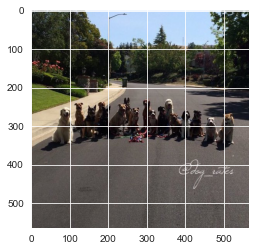

In [25]:
#https://stackoverflow.com/questions/12116050/how-to-plot-remote-image-from-http-url
image = io.imread('http://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg')
plt.imshow(image)
plt.show()

I have visually checked the Twitter page of the Tweet_id **832088576586297345** which is following site: https://twitter.com/dog_rates/status/832088576586297345. This tweet is not a typically dog-picture-rating, the rating_denominator of 15 and the rating_numerator of 11 results from the fact that the tweet text is "account started on 11/15/15" and that the programmatic extraction therefore gets "11/15" as a rating, which is not a rating but a date. So the dataset has false data in the ratings.  



I have visually checked the Twitter page of the Tweet_id **749981277374128128** which is following site https://twitter.com/dog_rates/status/749981277374128128: This Tweet indeed has a rating of 1776 (a dog with an American hat and an American flag in the background. 


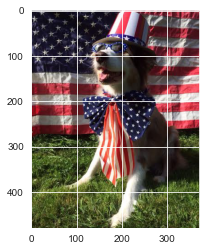

In [35]:
image = io.imread('https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg')
plt.imshow(image)
plt.show()

As the ratings seems in most cases be valid, I will create a new column "user_rating" which will be a division of the columns "rating_numerator"  and "rating_denominator". By this new column the ratings will be comparable independently how many dogs are in the picutre.

Futhermore, I will delete the tweet with the Tweet_id 832088576586297345, as the columns "rating_numerator"  and "rating_denominator" are actually dates.

#### analysing the column "name"

In [36]:
df_tw['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Cooper       11
           ... 
Hazel         1
Godzilla      1
Mookie        1
Rizzo         1
Millie        1
Name: name, Length: 957, dtype: int64

There seems to be names which are not names such as:
- *a* with a count of 55
- *an* with a count of 7
- *very* with a cont of 5
- and many more
There seems to be a logic, that if the dog name is lower-case then this is not a dog name. I will therefore replace lower-case dog names and the with an empty string "".
  
Furthermore there are 745 dogs without a name, these are indicated with the term "None". (None).  The column "name" does contain strings which are not dog names. However, None is in Pyhton a reserved term and might therefore provide problems in subsequent codes.

#### analysing the column "in_reply_to_status_id"

In [37]:
df_tw.shape

(2356, 17)

In [38]:
df_tw[df_tw['in_reply_to_status_id'].notna()] #display rows not NaN

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After countless hours of research and hundreds of formula alterations we have concluded that Dug should be bumped to an 11/10,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tessa. She is also very pleased after finally meeting her biological father. 10/10 https://t.co/qDS1aCqppv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438988365824/photo/1,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [39]:
df_tw['in_reply_to_status_id'].isnull().sum()

2278

The DataFrame df_tw has in total 2356 rows. The column "in_reply_to_status_id" is empty for 2278 rows and non-empty for 78 rows. The rows with a non-empty value will need to be deleted, as I will be focusing on original tweets only (i.e. I am not interessted in answers.)

#### column "source"

In [40]:
df_tw.groupby('source').count()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
source,,,,,,,,,,,,,,,,
"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",33,0,0,33,33,2,2,2,32,33,33,33,33,33,33,33
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",2221,78,78,2221,2221,179,179,179,2163,2221,2221,2221,2221,2221,2221,2221
"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",91,0,0,91,91,0,0,0,91,91,91,91,91,91,91,91
"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",11,0,0,11,11,0,0,0,11,11,11,11,11,11,11,11


I will create a new column containing only the device type such as "Twitter Web Client" or "Twitter for iPhone". I will isolate the device type.

<a id='Assess2b2'></a>
#### 2.2.2 Programmatic assessment of image prediction df_tw_prediction

In [41]:
df_tw_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [42]:
df_tw_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The results of the .info() analysis:
- The dataset does not have NaN values.  
- The datatype of the column "tweet_id" shall be corrected to string. All other columns are correct (for example the columns p1_dog, p2_dog and p3_dog are boolean datatype

In [43]:
#code from https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation
df_tw_prediction.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2075.00000,2075.00000,2075.00000,2075.00000,2075.00000
mean,738451357852539008.00000,1.20386,0.59455,0.13459,0.06032
std,67852033330235656.00000,0.56188,0.27117,0.10067,0.05091
min,666020888022790144.00000,1.00000,0.04433,0.00000,0.00000
25%,676483507139540992.00000,1.00000,0.36441,0.05389,0.01622
50%,711998809858043904.00000,1.00000,0.58823,0.11818,0.04944
75%,793203448525178880.00000,1.00000,0.84386,0.19557,0.09181
max,892420643555336192.00000,4.00000,1.00000,0.48801,0.27342


The results of the .describe() analysis are:
- the p1 probability is in average 0.59 with a minimum value of 0.00 and a maximum value of 1
- the p2 probability is in average 0.13 with a minimum value of 0.00 and a maximum value of 0.48
- the p1 probability is in average 0.06 with a minimum value of 0.00 and a maximum value of 0.27
Nothing unexpected with shall be adressed in either quality or tidyness from the .describe() analysis.

In [44]:
df_tw_prediction.query('p1_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2026,882045870035918850,https://pbs.twimg.com/media/DD2oCl2WAAEI_4a.jpg,1,web_site,0.949591,False,dhole,0.017326,False,golden_retriever,0.006941,True
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False


In [45]:
df_tw_prediction.query('p1_dog == False and p2_dog == False and p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


Analysis of the p1/p2/p3 columns:
- there are tweets with **three Falses**. I have visually analysed the Tweets on Twitter https://twitter.com/dog_rates/status/666051853826850816. For example: 
    - tweet_id #666051853826850816	 is a turtle 
    - tweet_id # 666268910803644416	is a dog in a mirrow
    - tweet_id #666983947667116034	is a dog with clothes on  
  
  When there are three falses, then the image prediction has not been able to detect the dog due to unclear image. I cannot   delete these picture, because some include a dog, whereas others include other animals such as a turtle. I will need to     rename the dog prediction column in "undefined" if there are three falses.  
  
- I will need to create one unique column with the dog breed that might either be p1 or p2 or p3 depending the column which is True. I will create one new column "dog_breed" and a second new column for the confidence intervall for "p_conf_dog_breed"

#### check for duplicates

In [46]:
df_tw_prediction['tweet_id'].duplicated().sum()

0

There are no duplicates in the tweet_id

In [47]:
df_tw_prediction['jpg_url'].duplicated().sum() #there are duplicates

66

In [48]:
df_tw_prediction [df_tw_prediction['jpg_url'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


In [49]:
df_tw_prediction [df_tw_prediction['jpg_url'] == "https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg"]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
713,685325112850124800,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.39826,True,kuvasz,0.00541,True
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.39826,True,kuvasz,0.00541,True


A visual assessment of tweet_id 685325112850124800 and 761750502866649088 confirms that both pictures are the same. The second one is a retweet.

In [50]:
df_tw_prediction.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
469,675111688094527488,https://pbs.twimg.com/media/CV56f54WsAEv4kJ.jpg,1,Labrador_retriever,0.631501,True,Brittany_spaniel,0.101927,True,Chesapeake_Bay_retriever,0.062650,True
847,695409464418041856,https://pbs.twimg.com/media/CaaXN5LUYAEzAh-.jpg,1,pug,0.997445,True,bull_mastiff,0.001749,True,Pekinese,0.000304,True
533,676897532954456065,https://pbs.twimg.com/media/CWTSt0UW4AALMNB.jpg,1,hamster,0.628255,False,guinea_pig,0.318646,False,macaque,0.013058,False
2053,887705289381826560,https://pbs.twimg.com/media/DFHDQBbXgAEqY7t.jpg,1,basset,0.821664,True,redbone,0.087582,True,Weimaraner,0.026236,True
238,670434127938719744,https://pbs.twimg.com/media/CU3cSG8W4AIAePH.jpg,1,jack-o'-lantern,0.919140,False,Chesapeake_Bay_retriever,0.027351,True,Labrador_retriever,0.020081,True


#### analysis of column img_num

In [51]:
df_tw_prediction['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

For the majority of the prediction tweets the first picture (1780) has been used by the algorithm, and then in a descending order picture 2 (198), then picture 3 (66) and then finally picture 4 (31). No quality or tidiness issue identified here.

<a id='Assess2b3'></a>
####  2.2.3 Programmatic assessment of Twitter API df_json_tweet

In [52]:
df_json_tweet.head(2)

,tweet_id,retweet_count,favorite_count,followers_count,device_type_API,media_url
0,892420643555336193,7405,35126,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,5514,30392,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg


In [53]:
df_json_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2328 non-null   int64 
 1   retweet_count    2328 non-null   int64 
 2   favorite_count   2328 non-null   int64 
 3   followers_count  2328 non-null   int64 
 4   device_type_API  2328 non-null   object
 5   media_url        2328 non-null   object
dtypes: int64(4), object(2)
memory usage: 109.2+ KB


The analysis based on .info() is as follows:
- there are no NaN in the columns
- the tweet_id datatype shall be string and not an integer.
- All other datatypes are corret: the datatypes int64 is correct.
- the datatype of device_type will need to be changed to categorial.

In [54]:
df_json_tweet.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,tweet_id,retweet_count,favorite_count,followers_count
count,2328.00000,2328.00000,2328.00000,2328.00000
mean,741966222831956096.00000,2604.33849,7339.61469,8956078.22294
std,68255063718676688.00000,4405.54912,11397.98363,44.55620
min,666020888022790144.00000,1.00000,0.00000,8956061.00000
25%,678197428948985856.00000,527.75000,1270.00000,8956070.00000
50%,718457365662691328.00000,1214.00000,3184.00000,8956071.00000
75%,798675474996203520.00000,3020.50000,8982.25000,8956072.00000
max,892420643555336192.00000,74738.00000,151053.00000,8956492.00000


The analysis based on .describe() is as follows:
- the retweet_count minimum is 1 retweet, an average of 2604 and a max of 74,738
- the favorite_count minimum is 0 favorite, an average of 7339 and a max of 151,053
- the retweet_count minimum is 8,956,061 retweet, an average of 8,956,061 and a max of 8,956,492
No quality of tidniness issue identified here.

<a id='summary'></a>
### Summary of assessment results

<font color='green'>
**The assessment results are:**    
    
<ins>*quality assessment results (content issue)*:</ins>   
  
`df_tw DataFrame`  
- (1) the column "tweet_id" shall be corrected for its **datatype**. At the momen it is an integer, however, it should be a string.
- (2) the column "timestamp" shall be corrected for its **datatype**. At the moment it is an object (string), however, this column should be a datetime object.
- (3) the columns "in_reply_to_status_id" and "in_reply_to_user_id" shall be corrected for its **datatype**. They are floats, but should be strings.
- (4) the columns "retweeted_status_id" and "retweeted_status_user_id" shall be corrected for its  **datatype**. They are floats, but should be strings.
- (5) the colums for the dog "stage" shall be corrected for its **datatype**. They are  of the datetype object, but should be categorial (doggo, floofer, pupper and puppo).
- (6) **create new column for device_type**: The column "source" contains a long text (string). I will isolate the information which I am interessted in.
- (7) **delete Tweets which are retweets** retweets are to be eliminated based on the projects instructions that only original ratings (no retweets) are wanted. The Tweets with the column "retweeted_status" non-empty will need to be deleted as well as following columns "retweeted_status_id", "retweeted_status_user_id", and "retweeted_status_timestamp" .
- (8) **delete Tweets without pictures** pursuant to the project's instructions only Tweets with pictures are wanted based on the projects instructions. Therefore I will delete Tweets without pictures in the dataframe df_tw_clean, based on info in column expanded_urls.
- (9) **replace lowercase dog names with an empty string ""** The column "name" does contain strings which are not dog names. I will replace all lower-case dog names (first letter is lower-case) with the term None. Furthermore I will replace the dogs name "None" with an empty string. "None" as a dog name is used in the dataset as a indicator that there is no name for the dog. However, None is in Pyhton specific code term and therefore I will remove it with an empty string "".
- (10) **delete Tweets which are answers**: The rows in column "in_reply_to_status_id" which are non-empty will be deleted.


`df_tw_prediction DataFrame` 
- (11) **delete the Tweet_id 832088576586297345**, as the columns "rating_numerator"  and "rating_denominator" are actually dates.
- (12) the column "tweet_id" shall be corrected for its **datatype**. At the momen it is an integer, however, it should be a string.
- (13) df_tw_prediction: if all three columns p1_dog and p2_dog and p3_dog have the value False, then I will input the data "undefined breed" in the dataset. 
- (14) **replace underscore with space**. The dog breed name in p1, p2 and p3 have an underscore _ whenever the dog breed name has a space. For visualisation purposes I will replace the underscore "_" with a space " ".
- (15) create a new column of the predicted dog breed with the highest probability score of the algorithm.

`df_json_tweet DataFrame` 
- (16) the column "tweet_id" shall be corrected for its **datatype**. At the momen it is an integer, however, it should be a string.
- (17) the column "device_type" need to be change to  the **datatype** categorial

<ins>*tidiness assessment results (structural issues)*:</ins>   
`df_tw DataFrame`  
- (1) in the columns doggo, floofer, pupper and puppo are not respecting the tidiness issue. I will need to set-up one unique column.
- (2) I will need to **merge** the three dataframe in one dataframe with only selected columns. The unique identfier is the Tweet_id
- (3a) create a new **column "user_rating"** as a division from the columns "rating_numerator" and "rating_denominator".
- (3b) delete the columns "rating_numerator" and "rating_denominator", which are not needed anymore due to step 3a.
- (4) delete columns "retweeted_status_id", "retweeted_status_user_id", and "retweeted_status_timestamp" once the retweeted data (see quality issue) are removed. (These columns are then empty and are to be removed)
- (5) delete all columns in df_combined_clean which are redundant and not needed for further analysis.



</font>

<a id='Clean'></a>
## Clean

Before starting the data cleaning steps I will make a copy of each dataframe. The cleaning will be done on the _clean dataframes.

In [23]:
df_tw_clean = df_tw.copy()
df_json_tweet_clean = df_json_tweet.copy()
df_tw_prediction_clean = df_tw_prediction.copy()

### Define  
Correct the **datatype** for the tweet_ID in all three datassets. The corrected datatype should be string (object).  
<font color='blue'>quality issues: (1) + (12) + (16)</font>

### Code

In [24]:
df_tw_clean['tweet_id'] = df_tw_clean['tweet_id'].apply(str)
df_json_tweet_clean['tweet_id'] = df_json_tweet_clean['tweet_id'].apply(str)
df_tw_prediction_clean['tweet_id'] = df_tw_prediction_clean['tweet_id'].apply(str)

### Test

In [25]:
df_tw_clean['tweet_id'].dtype

dtype('O')

In [26]:
df_json_tweet_clean['tweet_id'].dtype

dtype('O')

In [27]:
df_tw_prediction_clean['tweet_id'].dtype

dtype('O')

> Cleaning of the datatype for tweet_id successfull for all three dataframes. The new dataype is now dtype('O'), which is a Phyton object.

### Define 
Correct the datatype of the column "timestamp" in the dataframe df_tw_clean from old "object" to "datetime".  
<font color='blue'>quality issue: (2)</font>

In [28]:
df_tw_clean['timestamp'].dtype

dtype('O')

### Code

In [29]:
df_tw_clean['timestamp'] = pd.to_datetime(df_tw_clean['timestamp'])

### Test

In [30]:
df_tw_clean['timestamp'].dtype

datetime64[ns, UTC]

> Cleaning of the datatype for timestamp successfull for the dataframe df_tw_clean. The new dataype is now a datetime object.

### Define 
Correct the datatype of the "in_reply_to_status_id" and "in_reply_to_user_id" from old floats to objects.   
Correct the datatype of the "retweeted_status_id" and "retweeted_status_user_id" from old floats to objects.  
<font color='blue'>quality issue: (3) + (4)</font>

In [31]:
df_tw_clean['in_reply_to_status_id'].dtype

dtype('float64')

In [32]:
df_tw_clean['in_reply_to_user_id'].dtype

dtype('float64')

In [33]:
df_tw_clean['retweeted_status_id'].dtype

dtype('float64')

In [34]:
df_tw_clean['retweeted_status_user_id'].dtype

dtype('float64')

### Code

In [35]:
def change_dtype_to_int(column_name):
    try: 
        df_tw_clean[column_name] = df_tw_clean[column_name].astype(str)
    except:
        pass


In [36]:
change_dtype_to_int('in_reply_to_status_id')
change_dtype_to_int('in_reply_to_user_id')
change_dtype_to_int('retweeted_status_id')
change_dtype_to_int('retweeted_status_user_id')

### Test

In [37]:
df_tw_clean['tweet_id'].dtype

dtype('O')

In [38]:
df_tw_clean['in_reply_to_status_id'].dtype

dtype('O')

In [39]:
df_tw_clean['in_reply_to_user_id'].dtype

dtype('O')

In [40]:
df_tw_clean['retweeted_status_id'].dtype

dtype('O')

In [41]:
df_tw_clean['retweeted_status_user_id'].dtype

dtype('O')

> Cleaning of the datatype for the columns "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id" and "retweeted_status_user_id" successfull for the dataframe df_tw_clean. The new dataype is now a string (object).

### Define 
Correct the datatype of the columns "doggo", "floofer", "pupper" and "puppo" (5). They are  of the datetype object, but should be categorial.  
<font color='blue'>quality issue: (5)</font>

In [42]:
df_tw_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       2356 non-null   object             
 2   in_reply_to_user_id         2356 non-null   object             
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         2356 non-null   object             
 7   retweeted_status_user_id    2356 non-null   object             
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Code

In [43]:
def change_dtype_to_cat(column_name):
    df_tw_clean[column_name]= df_tw_clean[column_name].astype('category')

In [44]:
change_dtype_to_cat('doggo')
change_dtype_to_cat('floofer')
change_dtype_to_cat('pupper')
change_dtype_to_cat('puppo')


### Test

In [45]:
df_tw_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       2356 non-null   object             
 2   in_reply_to_user_id         2356 non-null   object             
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         2356 non-null   object             
 7   retweeted_status_user_id    2356 non-null   object             
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

> Cleaning of the datatype for the columns "doggo", "floofer", "pupper" and "puppo" successfull for the dataframe df_tw_clean. The new dataype is now category.

### Define 
create new column for device_type in the dataframe df_tw_clean. This will be done by apply in the "source" column a slicing.  
<font color='blue'>quality issue: (6)</font>

### Code

In [46]:
df_tw_clean['device_type'] = df_tw_clean['source'].str.extract('>(.*?)<', expand=True)

### Test

In [47]:
df_tw_clean['device_type'].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: device_type, dtype: int64

> The creation of the new column "device_type" was successfull.

### Define 
Delete Tweets which are retweets in the dataframe df_tw_clean. Columns: retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp  
<font color='blue'>quality issue: (7)</font>

In [48]:
df_tw_clean.query('retweeted_status_id != "nan"')['retweeted_status_id']

19      8.874739571039519e+17
32      8.860537344211026e+17
36      8.305833205850685e+17
68      8.780576130401157e+17
73      8.782815110064783e+17
                ...          
1023    6.678667242938778e+17
1043    6.671382696715059e+17
1242    7.119982797733478e+17
2259    6.675486956640707e+17
2260     6.67548415174144e+17
Name: retweeted_status_id, Length: 181, dtype: object

### Code 

In [49]:
df_tw_clean = df_tw_clean.drop(df_tw_clean[df_tw_clean['retweeted_status_id'] != "nan"].index)

### Test

In [50]:
df_tw_clean['retweeted_status_id'].value_counts()

nan    2175
Name: retweeted_status_id, dtype: int64

In [51]:
df_tw_clean['retweeted_status_user_id'].value_counts()

nan    2175
Name: retweeted_status_user_id, dtype: int64

In [52]:
df_tw_clean['retweeted_status_timestamp'].value_counts()

Series([], Name: retweeted_status_timestamp, dtype: int64)

> The dataframe df_tw_clean does not contain anymore Tweets which are retweets.


### Define 
Delete Tweets without pictures in the dataframe df_tw_clean, based on info in column expanded_urls.  
<font color='blue'>quality issue: (8)</font>

In [53]:
df_tw_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2175 non-null   object             
 1   in_reply_to_status_id       2175 non-null   object             
 2   in_reply_to_user_id         2175 non-null   object             
 3   timestamp                   2175 non-null   datetime64[ns, UTC]
 4   source                      2175 non-null   object             
 5   text                        2175 non-null   object             
 6   retweeted_status_id         2175 non-null   object             
 7   retweeted_status_user_id    2175 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2175 non-null   int64           

In [54]:
#calculate number of nan rows in the column expanded_urls
df_tw_clean[df_tw_clean['expanded_urls'].isna()].shape

(58, 18)

58 rows matches with the result from .info()

### Code 

In [55]:
#deletes all rows where the column expanded_urls has Nans.
df_tw_clean.dropna(subset=['expanded_urls'], inplace=True)

### Test

In [56]:
df_tw_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2117 non-null   object             
 1   in_reply_to_status_id       2117 non-null   object             
 2   in_reply_to_user_id         2117 non-null   object             
 3   timestamp                   2117 non-null   datetime64[ns, UTC]
 4   source                      2117 non-null   object             
 5   text                        2117 non-null   object             
 6   retweeted_status_id         2117 non-null   object             
 7   retweeted_status_user_id    2117 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2117 non-null   int64           

> The dataframe df_tw_clean does not contain anymore Tweets without pictures (the number of picutres in column expanded_url is 2117 which is also the total number of entries in this datafram.)

### Define 
Replace lowercase dog names with an empty string. And replace dog name None with an empty string.  
<font color='blue'>quality issue: (9)</font>

In [57]:
#display an extract of the column name:
df_tw_clean['name']

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           a
2353           a
2354           a
2355        None
Name: name, Length: 2117, dtype: object

In [58]:
#display all rows with a lowercase first letter in the column name:
df_tw_clean[df_tw_clean['name'].str[0].str.islower()]['name']

22       such
56          a
169     quite
193     quite
335       not
        ...  
2349       an
2350        a
2352        a
2353        a
2354        a
Name: name, Length: 104, dtype: object

### Code 

In [59]:
#part 1: replace lowercase names with an empty string ""
#code from https://www.kite.com/python/answers/how-to-replace-values-in-a-pandas-%60dataframe%60-column-based-on-a-conditional-expression-in-python#:~:text=loc()%20to%20replace%20values,the%20new%20value%20to%20assign.
df_tw_clean['name'] = np.where(df_tw_clean['name'].str[0].str.islower(), "", df_tw_clean["name"])

In [60]:
#part 2: replace the term None with an empty string ""
df_tw_clean['name'] = np.where(df_tw_clean['name']== "None", "", df_tw_clean["name"])

### Test

In [61]:
df_tw_clean.query('name == "None"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,device_type


In [62]:
df_tw_clean.query('name == "None"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,device_type


In [63]:
df_tw_clean.groupby(['name']).count()['tweet_id']

name
         726
Abby       2
Ace        1
Acro       1
Adele      1
        ... 
Ziva       1
Zoe        1
Zoey       3
Zooey      1
Zuzu       1
Name: tweet_id, Length: 931, dtype: int64

> The dataframe df_tw_clean has been cleaned for dog names which are not dogs names (lowercase and None).

### Define 
delete rows in column "in_reply_to_status_id" which do not contain the string "nan" will be deleted.  
<font color='blue'>quality issue: (10)</font>

In [64]:
df_tw_clean.query('in_reply_to_status_id != "nan"').shape

(23, 18)

There are 78 rows to be deleted.

In [65]:
#shaep before
df_tw_clean.shape

(2117, 18)

### Code 

In [66]:
df_tw_clean = df_tw_clean[df_tw_clean['in_reply_to_status_id'] == "nan"]

### Test

In [67]:
#shape after
df_tw_clean.shape

(2094, 18)

In [68]:
df_tw_clean.query('in_reply_to_status_id != "nan"').shape

(0, 18)

> The dataframe df_tw_clean has been cleaned for Tweets which are answers.

### Define 
delete the Tweet_id 832088576586297345  
<font color='blue'>quality issue: (11)</font>

In [69]:
df_tw_clean.query('tweet_id == "832088576586297345"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,device_type


In [70]:
df_json_tweet_clean.query('tweet_id == "832088576586297345"')

,tweet_id,retweet_count,favorite_count,followers_count,device_type_API,media_url
328,832088576586297345,2,61,8956071,Twitter for iPhone,http://pbs.twimg.com/media/CwJR1okWIAA6XMp.jpg


In [71]:
df_tw_prediction_clean.query('tweet_id == "832088576586297345"')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


The Tweet 832088576586297345 is already deleted in the dataframe df_tw_clean due to the cleaning of the quality issue #8 expanded_urls.

### Code 

In [72]:
df_json_tweet_clean = df_json_tweet_clean.query('tweet_id != "832088576586297345"')

### Test

In [73]:
df_json_tweet_clean.query('tweet_id == "832088576586297345"')

,tweet_id,retweet_count,favorite_count,followers_count,device_type_API,media_url


> The dataframe df_tw_clean has been cleaned for Tweets  832088576586297345.

### Define 
If the columns p1_dog and p2_dog and p3_dog have False in the dataframe df_tw_prediction_clean, then I will input the data "undefined" in the dataset.   
<font color='blue'>quality issue: (13)</font>

In [74]:
df_tw_prediction_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [75]:
df_tw_prediction_clean.query('p1_dog == False and p2_dog == False and p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


### Code 

In [76]:
df_tw_prediction_clean['sum'] = df_tw_prediction_clean['p1_dog']+\
df_tw_prediction_clean['p2_dog']+df_tw_prediction_clean['p3_dog']

df_tw_prediction_clean.loc[df_tw_prediction_clean['sum'] == False, 'p1'] = "undefined"
df_tw_prediction_clean.loc[df_tw_prediction_clean['sum'] == False, 'p2'] = "undefined"
df_tw_prediction_clean.loc[df_tw_prediction_clean['sum'] == False, 'p3'] = "undefined"

df_tw_prediction_clean.drop('sum', axis=1, inplace=True)

C:\Users\Madeleine\Documents\Python\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


### Test

In [77]:
df_tw_prediction_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [78]:
df_tw_prediction_clean.query('p1_dog == False and p2_dog == False and p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,undefined,0.933012,False,undefined,0.045885,False,undefined,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,undefined,0.965932,False,undefined,0.033919,False,undefined,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,undefined,0.086502,False,undefined,0.085547,False,undefined,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,undefined,0.914671,False,undefined,0.015250,False,undefined,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,undefined,0.996496,False,undefined,0.002402,False,undefined,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,undefined,0.251801,False,undefined,0.115123,False,undefined,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,undefined,0.473303,False,undefined,0.245646,False,undefined,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,undefined,0.738995,False,undefined,0.139952,False,undefined,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg,1,undefined,0.130432,False,undefined,0.029175,False,undefined,0.026321,False


> The dataframe df_tw_prediction_clean does now contain the term undefined when all three algorithm have the result False.

### Define 
In the dataframe df_tw_prediction in the columns p1, p2, p3 geplace the underscore with a space.   
<font color='blue'>quality issue: (14)</font>

In [79]:
df_tw_prediction_clean[['p1_dog','p1', 'p2', 'p3']].sample(5)

,p1_dog,p1,p2,p3
496,True,Maltese_dog,West_Highland_white_terrier,toy_poodle
246,False,undefined,undefined,undefined
2040,True,malamute,Siberian_husky,Eskimo_dog
125,True,Chihuahua,miniature_pinscher,toy_terrier
572,True,schipperke,Labrador_retriever,kelpie


### Code 

In [80]:
def replace_underscore(column_name):
    df_tw_prediction_clean[column_name]= df_tw_prediction_clean[column_name].replace('_', ' ', regex=True)


replace_underscore('p1')
replace_underscore('p2')
replace_underscore('p3')

### Test

In [81]:
df_tw_prediction_clean[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,Welsh springer spaniel,collie,Shetland sheepdog
1,redbone,miniature pinscher,Rhodesian ridgeback
2,German shepherd,malinois,bloodhound
3,Rhodesian ridgeback,redbone,miniature pinscher
4,miniature pinscher,Rottweiler,Doberman


In [82]:
df_tw_prediction_clean['p1'].str.count('_').sum()+ df_tw_prediction_clean['p2'].str.count('_').sum() +df_tw_prediction_clean['p3'].str.count('_').sum()

0

> The dataframe df_tw_clean has been cleaned for dog names which are not dogs names (lowercase and None).

### Define 
New column for the highest predicted dog breed.  
<font color='blue'>quality issue: (15)</font>


In [83]:
df_tw_prediction_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True


In [84]:
df_tw_prediction_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True


### Code 

In [85]:
#code from https://stackoverflow.com/questions/57437614/using-np-select-to-generate-conditional-column-based-off-data-from-multiple-othe

# create a list of the conditions
conditions = [(df_tw_prediction_clean['p1_dog'] == True),(df_tw_prediction_clean['p2_dog'] == True),(df_tw_prediction_clean['p3_dog'] == True)]

# create a list of the values we want to assign for each condition
values = [(df_tw_prediction_clean['p1']),(df_tw_prediction_clean['p2']),(df_tw_prediction_clean['p3'])]

# create a new column and use np.select to assign values to it using our lists as arguments
df_tw_prediction_clean['predicted_breed'] = np.select(conditions, values, default=np.nan)



### Test

In [86]:
df_tw_prediction_clean.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_breed
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,basset
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper towel,0.170278,False,Labrador retriever,0.168086,True,spatula,0.040836,False,Labrador retriever
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,Chihuahua
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,undefined,0.097049,False,undefined,0.085851,False,undefined,0.076110,False,NaN


> The dataframe df_tw_prediction_clean does now contain a new colum "predicted_breed" for the one breed prediction which is True.

### Define 
The device_type of the dataframe df_json_tweet should be category.  
<font color='blue'>quality issue: (16)</font>

In [87]:
df_json_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 2327
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2327 non-null   object
 1   retweet_count    2327 non-null   int64 
 2   favorite_count   2327 non-null   int64 
 3   followers_count  2327 non-null   int64 
 4   device_type_API  2327 non-null   object
 5   media_url        2327 non-null   object
dtypes: int64(3), object(3)
memory usage: 127.3+ KB


### Code 

In [88]:
df_json_tweet_clean['device_type_API']= df_json_tweet_clean['device_type_API'].astype('category')

### Test

In [89]:
df_json_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 2327
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tweet_id         2327 non-null   object  
 1   retweet_count    2327 non-null   int64   
 2   favorite_count   2327 non-null   int64   
 3   followers_count  2327 non-null   int64   
 4   device_type_API  2327 non-null   category
 5   media_url        2327 non-null   object  
dtypes: category(1), int64(3), object(2)
memory usage: 111.5+ KB


> The column "device_type" in the dataframe df_json_tweet_clean is now of the datatype categorial.

### Define 
Create in the dataframe df_tw_clean a new column for either doggo, floofer, pupper and puppo, depending which one is available.  
<font color='green'>tidiness issue: (1)</font>

In [90]:
df_tw_clean['doggo'].value_counts()

None     2011
doggo      83
Name: doggo, dtype: int64

In [91]:
df_tw_clean['floofer'].value_counts()

None       2084
floofer      10
Name: floofer, dtype: int64

In [92]:
df_tw_clean['pupper'].value_counts()

None      1865
pupper     229
Name: pupper, dtype: int64

In [93]:
df_tw_clean['puppo'].value_counts()

None     2070
puppo      24
Name: puppo, dtype: int64

### Code 

In [94]:
#first step: replace None with an empty string ""
df_tw_clean['doggo'] = np.where(df_tw_clean['doggo']== "None", "", df_tw_clean["doggo"])
df_tw_clean['floofer'] = np.where(df_tw_clean['floofer']== "None", "", df_tw_clean["floofer"])
df_tw_clean['pupper'] = np.where(df_tw_clean['pupper']== "None", "", df_tw_clean["pupper"])
df_tw_clean['puppo'] = np.where(df_tw_clean['puppo']== "None", "", df_tw_clean["puppo"])

In [95]:
df_tw_clean['dog_type_category'] = pd.Series(df_tw_clean['doggo'] + df_tw_clean['floofer'] + df_tw_clean['pupper'] + df_tw_clean['puppo'] )

### Test

In [96]:
df_tw_clean['doggo'].value_counts()

         2011
doggo      83
Name: doggo, dtype: int64

In [97]:
df_tw_clean['floofer'].value_counts()

           2084
floofer      10
Name: floofer, dtype: int64

In [98]:
df_tw_clean['pupper'].value_counts()

          1865
pupper     229
Name: pupper, dtype: int64

In [99]:
df_tw_clean['puppo'].value_counts()

         2070
puppo      24
Name: puppo, dtype: int64

In [100]:
df_tw_clean['dog_type_category'].value_counts()

                1759
pupper           220
doggo             72
puppo             23
doggopupper        9
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_type_category, dtype: int64

> A  new column dog_type_category has been created based on the existing columns doggo, floofer, pupper and puppo.

### Define 
Merge all three  three dataframe in one dataframe based on the unique identfier is the Tweet_id.  
<font color='green'>tidiness issue: (2)</font>

In [101]:
df_tw_clean.shape

(2094, 19)

In [102]:
df_json_tweet_clean.shape

(2327, 6)

In [103]:
df_tw_prediction_clean.shape

(2075, 13)

In [104]:
df_tw_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,device_type,dog_type_category
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,,,,,Twitter for iPhone,
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,,,,,Twitter for iPhone,


In [105]:
df_json_tweet_clean.head(2)

,tweet_id,retweet_count,favorite_count,followers_count,device_type_API,media_url
0,892420643555336193,7405,35126,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,5514,30392,8956072,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg


In [106]:
df_tw_prediction_clean.tail(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_breed
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,undefined,0.097049,False,undefined,0.085851,False,undefined,0.076110,False,NaN


### Code 

In [107]:
#use a first merge for the first two dataframes
df_combined_clean = df_tw_clean.merge(df_json_tweet_clean, left_on='tweet_id', right_on='tweet_id', how="outer")

In [108]:
#use a second merge for the third dataframe
df_combined_clean = df_combined_clean.merge(df_tw_prediction_clean, left_on='tweet_id', right_on='tweet_id', how="outer")

### Test

In [109]:
df_combined_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,device_type,dog_type_category,retweet_count,favorite_count,followers_count,device_type_API,media_url,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_breed
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,,,,,Twitter for iPhone,,7405.0,35126.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,undefined,0.097049,False,undefined,0.085851,False,undefined,0.076110,False,NaN
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,,,,,Twitter for iPhone,,5514.0,30392.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua


In [110]:
df_combined_clean.shape

(2346, 36)

In [111]:
df_combined_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2346 entries, 0 to 2345
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2346 non-null   object             
 1   in_reply_to_status_id       2094 non-null   object             
 2   in_reply_to_user_id         2094 non-null   object             
 3   timestamp                   2094 non-null   datetime64[ns, UTC]
 4   source                      2094 non-null   object             
 5   text                        2094 non-null   object             
 6   retweeted_status_id         2094 non-null   object             
 7   retweeted_status_user_id    2094 non-null   object             
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2094 non-null   float64         

> A new combined dataset called df_combined_clean has been created.

### Define 
create new column "user_rating" in the dataframe df_combined_clean (division from the columns "rating_numerator" and "rating_denominator"), and then delete the column "rating_numerator" and "rating_denominator" in Define 3b.  
<font color='green'>tidiness issue: (3a)</font>

In [112]:
df_combined_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,device_type,dog_type_category,retweet_count,favorite_count,followers_count,device_type_API,media_url,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_breed
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,,,,,Twitter for iPhone,,7405.0,35126.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,undefined,0.097049,False,undefined,0.085851,False,undefined,0.07611,False,NaN


### Code 

In [113]:
df_combined_clean['user_rating'] = df_combined_clean['rating_numerator'] / df_combined_clean['rating_denominator']

### Test

In [114]:
df_combined_clean[['user_rating', 'rating_numerator', 'rating_denominator']][500:510]

,user_rating,rating_numerator,rating_denominator
500,1.2,12.0,10.0
501,1.2,12.0,10.0
502,1.2,12.0,10.0
503,1.2,12.0,10.0
504,1.2,12.0,10.0
505,1.1,11.0,10.0
506,1.2,12.0,10.0
507,1.1,11.0,10.0
508,1.2,12.0,10.0
509,1.3,13.0,10.0


> New column successfully created.

### Define 
 delete the column "rating_numerator" and "rating_denominator" in the dataframe df_combined_clean.  
<font color='green'>tidiness issue: (3b)</font>

### Code 

In [115]:
df_combined_clean.drop(columns= ['rating_numerator', 'rating_denominator'], inplace=True)

### Test

In [116]:
df_combined_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo,device_type,dog_type_category,retweet_count,favorite_count,followers_count,device_type_API,media_url,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_breed,user_rating
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,,,,,Twitter for iPhone,,7405.0,35126.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,undefined,0.097049,False,undefined,0.085851,False,undefined,0.076110,False,NaN,1.3
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,,,,,Twitter for iPhone,,5514.0,30392.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua,1.3


> Columns successfully deleted.

### Define 
Delete columns "retweeted_status_id", "retweeted_status_user_id", and "retweeted_status_timestamp" once the retweeted data (see quality issue) are removed. (These columns are then empty and are to be removed)  
<font color='green'>tidiness issue: (4)</font>

In [117]:
df_combined_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo,device_type,dog_type_category,retweet_count,favorite_count,followers_count,device_type_API,media_url,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_breed,user_rating
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,,,,,Twitter for iPhone,,7405.0,35126.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,undefined,0.097049,False,undefined,0.085851,False,undefined,0.076110,False,NaN,1.3
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,,,,,Twitter for iPhone,,5514.0,30392.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua,1.3


In [118]:
df_combined_clean['retweeted_status_id'].value_counts()

nan    2094
Name: retweeted_status_id, dtype: int64

In [119]:
df_combined_clean['retweeted_status_user_id'].value_counts()

nan    2094
Name: retweeted_status_user_id, dtype: int64

In [120]:
df_combined_clean['retweeted_status_timestamp'].value_counts()

Series([], Name: retweeted_status_timestamp, dtype: int64)

### Code 

In [121]:
df_combined_clean.drop(columns= ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)

### Test

In [122]:
df_combined_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,device_type,dog_type_category,retweet_count,favorite_count,followers_count,device_type_API,media_url,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_breed,user_rating
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,,,,,Twitter for iPhone,,7405.0,35126.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,undefined,0.097049,False,undefined,0.085851,False,undefined,0.076110,False,NaN,1.3
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,,,,,Twitter for iPhone,,5514.0,30392.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua,1.3


> Columns successfully dropped.

### Define 
Delete redundant columns.  
<font color='green'>tidiness issue: (4)</font>

In [123]:
df_combined_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,device_type,dog_type_category,retweet_count,favorite_count,followers_count,device_type_API,media_url,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,predicted_breed,user_rating
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,,,,,Twitter for iPhone,,7405.0,35126.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,undefined,0.097049,False,undefined,0.085851,False,undefined,0.076110,False,NaN,1.3
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,,,,,Twitter for iPhone,,5514.0,30392.0,8956072.0,Twitter for iPhone,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua,1.3


In [124]:
df_combined_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2346 entries, 0 to 2345
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2346 non-null   object             
 1   in_reply_to_status_id  2094 non-null   object             
 2   in_reply_to_user_id    2094 non-null   object             
 3   timestamp              2094 non-null   datetime64[ns, UTC]
 4   source                 2094 non-null   object             
 5   text                   2094 non-null   object             
 6   expanded_urls          2094 non-null   object             
 7   name                   2094 non-null   object             
 8   doggo                  2094 non-null   object             
 9   floofer                2094 non-null   object             
 10  pupper                 2094 non-null   object             
 11  puppo                  2094 non-null   object           

In [125]:
df_combined_clean['in_reply_to_status_id'].value_counts()

nan    2094
Name: in_reply_to_status_id, dtype: int64

In [126]:
df_combined_clean['in_reply_to_user_id'].value_counts()

nan    2094
Name: in_reply_to_user_id, dtype: int64

In [127]:
df_combined_clean.filter(like='device_type')

,device_type,device_type_API
0,Twitter for iPhone,Twitter for iPhone
1,Twitter for iPhone,Twitter for iPhone
2,Twitter for iPhone,Twitter for iPhone
3,Twitter for iPhone,Twitter for iPhone
4,Twitter for iPhone,Twitter for iPhone
...,...,...
2341,NaN,NaN
2342,NaN,NaN
2343,NaN,NaN
2344,NaN,NaN


### Code 

In [128]:
#store column names, which shall be deleted in a variable
columns_to_delete = ['in_reply_to_status_id', 'in_reply_to_user_id', 'doggo','floofer','pupper', 'puppo', 
                     'device_type_API', 'p1_dog', 'p2_dog', 'p3_dog', 'p2_conf', 'p1_conf' ,'p3_conf', 'p1', 'p2', 'p3', 
                    'source', 'expanded_urls' ,'jpg_url' ]



In [129]:
df_combined_clean.drop( columns=columns_to_delete, inplace=True)

### Test

In [130]:
df_combined_clean.head()

,tweet_id,timestamp,text,name,device_type,dog_type_category,retweet_count,favorite_count,followers_count,media_url,img_num,predicted_breed,user_rating
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas,Twitter for iPhone,,7405.0,35126.0,8956072.0,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,NaN,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,Twitter for iPhone,,5514.0,30392.0,8956072.0,http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,1.3
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,Twitter for iPhone,,3638.0,22849.0,8956072.0,http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,1.2
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla,Twitter for iPhone,,7584.0,38404.0,8956072.0,http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Labrador retriever,1.3
4,891327558926688256,2017-07-29 16:00:24+00:00,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",Franklin,Twitter for iPhone,,8159.0,36657.0,8956072.0,http://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,2.0,basset,1.2


In [131]:
df_combined_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2346 entries, 0 to 2345
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tweet_id           2346 non-null   object             
 1   timestamp          2094 non-null   datetime64[ns, UTC]
 2   text               2094 non-null   object             
 3   name               2094 non-null   object             
 4   device_type        2094 non-null   object             
 5   dog_type_category  2094 non-null   object             
 6   retweet_count      2327 non-null   float64            
 7   favorite_count     2327 non-null   float64            
 8   followers_count    2327 non-null   float64            
 9   media_url          2327 non-null   object             
 10  img_num            2075 non-null   float64            
 11  predicted_breed    1751 non-null   object             
 12  user_rating        2094 non-null   float64      

> Columns successfully dropped.

<a id='Analysis&Visualization'></a>
## Analysis&Visualization

### Gaining Insights

### store the clean dataframe as "twitter_archive_master.csv"

In [132]:
df_combined_clean.to_csv(r'twitter_archive_master.csv',index=False )

<a id='question1'></a>
#### Which dog stages are the most liked ones?

In [165]:
df_combined_clean['dog_type_category'].value_counts()

                1759
pupper           220
doggo             72
puppo             23
floofer            9
doggopupper        9
doggofloofer       1
doggopuppo         1
Name: dog_type_category, dtype: int64

> There seems to be many empty NaN dog tpypes, therefore I will create a new dataframe by deleting the tweets without the empty dog stage.

In [166]:
df_combined_clean_dog_stage = df_combined_clean.query('dog_type_category !=""')

In [167]:
df_combined_clean_dog_stage['dog_type_category'].value_counts()

pupper          220
doggo            72
puppo            23
floofer           9
doggopupper       9
doggofloofer      1
doggopuppo        1
Name: dog_type_category, dtype: int64

Text(0.5, 1.0, 'Number of Tweets by Dog Stage')

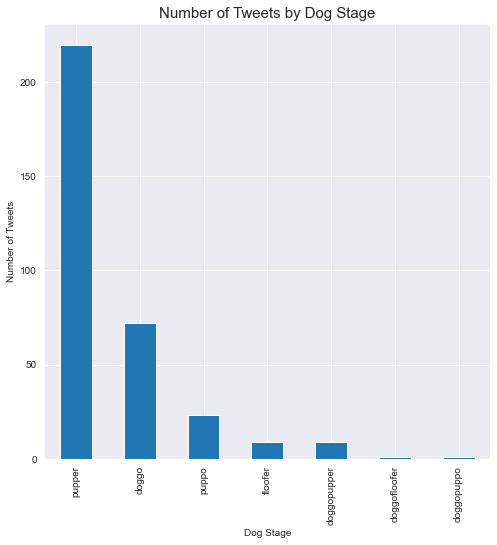

In [168]:
df_combined_clean_dog_stage['dog_type_category'].value_counts().plot(kind='bar', figsize=(8,8));
plt.ylabel('Number of Tweets')
plt.xlabel('Dog Stage')
plt.title('Number of Tweets by Dog Stage', fontsize=15)

> The dog stage "pupper" seems by far the most tweeted dog stage; under the constraint that the majority of the tweets does not contain any dog stage information.

<a id='question2'></a>
#### How did the number of Tweets for the Twitter Account WeRateDogs changed over the time?

In [169]:
#create a new column for the "year/month" of the tweet
df_combined_clean_tweet_time = df_combined_clean.copy()

#code from : https://dfrieds.com/data-analysis/create-year-month-column.html
df_combined_clean_tweet_time['year_month']= df_combined_clean_tweet_time['timestamp'].dt.strftime('%Y-%m')


In [170]:
df_combined_clean_tweet_time['year_month'].value_counts()

2015-12    372
2015-11    296
2016-01    183
2016-03    132
2016-02    120
2016-07     96
2016-06     90
2016-10     71
2016-09     69
2017-01     69
2017-02     67
2016-08     61
2016-04     60
2016-05     59
2016-12     57
2016-11     54
2017-03     52
2017-07     51
2017-06     48
2017-05     43
2017-04     42
2017-08      2
Name: year_month, dtype: int64

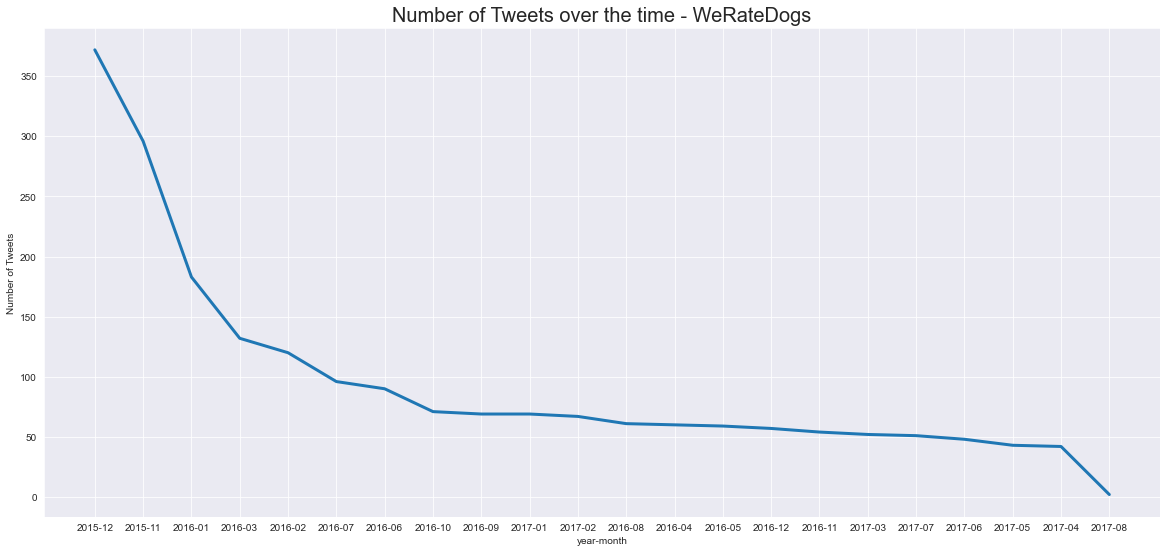

In [171]:
plot_data_tweet_time = df_combined_clean_tweet_time['year_month'].value_counts()

plt.figure(figsize=(20,9))
plt.plot(plot_data_tweet_time, label='mean of revenue', linewidth=3)

plt.ylabel('Number of Tweets')
plt.xlabel('year-month')
plt.title('Number of Tweets over the time - WeRateDogs', fontsize=20);

> The number of tweets has declined over time.

> The plot displays data from 2015 to 2017 only, because the tweet time is originated from the Tweet archive as provided by Udacity (dataframe: df_json_tweet_clean).

<a id='question3'></a>
#### Which dog name is the most popular one?

In [172]:
df_combined_clean.shape

(2346, 13)

In [173]:
df_combined_clean['name'].value_counts()

           704
Lucy        11
Charlie     11
Oliver      10
Cooper      10
          ... 
Meera        1
Tupawc       1
Livvie       1
Fillup       1
Rumble       1
Name: name, Length: 930, dtype: int64

> The dog name "Lucy" and "Charly" are the most popular ones, under the restriction that they have a individually a total count of 11, when the total dataset has 2346 datapoints.

<a id='question4'></a>
#### Which device type is the most popular one used for Tweeting?

In [174]:
df_combined_clean['device_type'].value_counts()

Twitter for iPhone     1962
Vine - Make a Scene      91
Twitter Web Client       30
TweetDeck                11
Name: device_type, dtype: int64

> The tweets are predominantly done via the I-Phone.

<a id='question5'></a>
#### Which dog breed is the most successfull one with regards to retweets?

In [175]:
df_combined_clean.head(1)

,tweet_id,timestamp,text,name,device_type,dog_type_category,retweet_count,favorite_count,followers_count,media_url,img_num,predicted_breed,user_rating
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas,Twitter for iPhone,,7405.0,35126.0,8956072.0,http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,NaN,1.3


In [176]:
df_combined_clean['predicted_breed'].value_counts()

golden retriever        173
Labrador retriever      113
Pembroke                 96
Chihuahua                95
pug                      65
                       ... 
silky terrier             1
Bouvier des Flandres      1
Irish wolfhound           1
EntleBucher               1
standard schnauzer        1
Name: predicted_breed, Length: 113, dtype: int64

In [177]:
df_combined_clean.groupby('predicted_breed').sum()['retweet_count'].nlargest(10)

predicted_breed
golden retriever      600281.0
Labrador retriever    366389.0
Pembroke              247990.0
Chihuahua             239393.0
Samoyed               201368.0
cocker spaniel        143861.0
French bulldog        139039.0
chow                  124551.0
pug                   110910.0
malamute               97109.0
Name: retweet_count, dtype: float64

In [178]:
#get x_ticks labels
#code from https://stackoverflow.com/questions/21800169/python-pandas-get-index-of-rows-which-column-matches-certain-value
x_tick_name= pd.DataFrame(df_combined_clean.groupby('predicted_breed').sum()['retweet_count'].nlargest(10))
x_tick_name = x_tick_name.index[:]
#x_tick_name = x_tick_name['predicted_breed']

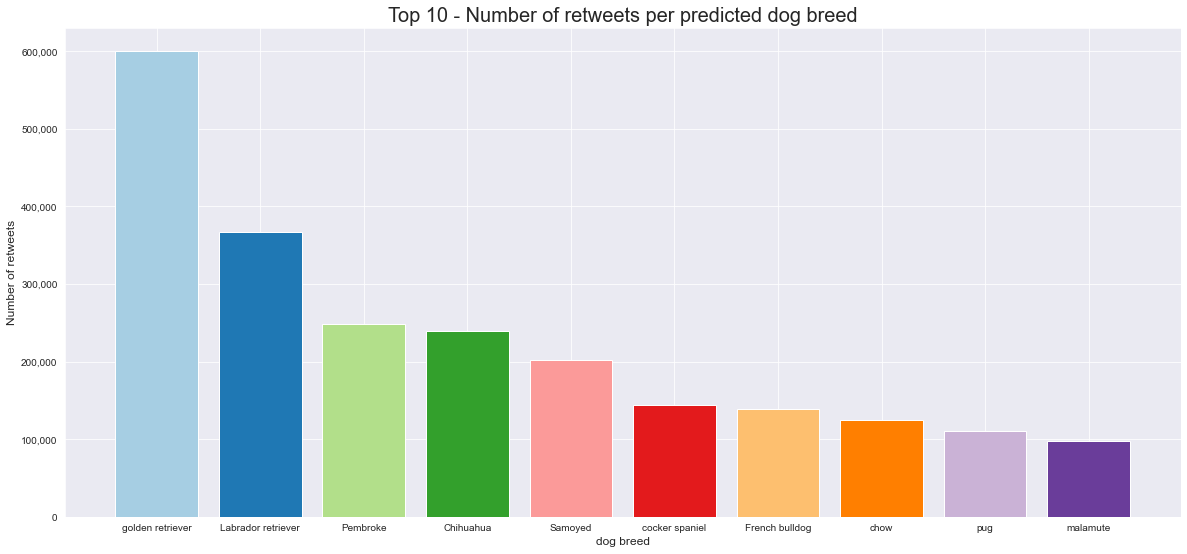

In [179]:
#code partially inspired from: https://stackoverflow.com/questions/44493417/pandas-dataframe-bar-plot-plot-bars-different-colors-from-specific-colormap

ind = np.arange(len(df_combined_clean.groupby('predicted_breed').sum()['retweet_count'].nlargest(10)))  # the x locations for the groups

plot_data_retweet_by_breed = df_combined_clean.groupby('predicted_breed').sum()['retweet_count'].nlargest(10)


plt.figure(figsize=(20,9))
ax= plt.bar(ind, plot_data_retweet_by_breed, color=plt.cm.Paired(np.arange(len(plot_data_retweet_by_breed))))

#format y axis:  code from: https://stackoverflow.com/questions/25973581/how-do-i-format-axis-number-format-to-thousands-with-a-comma-in-matplotlib/44444489
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}')) 


plt.ylabel('Number of retweets', fontsize=12)
plt.xlabel('dog breed', fontsize=12)
plt.title('Top 10 - Number of retweets per predicted dog breed', fontsize=20);


locations =[0,1,2,3,4,5,6,7,8,9] 
labels = x_tick_name  # xtick labels
plt.xticks(locations, labels);

> It seems that the breed "golden retriever" is the most successfull one with regards to retweets, followed by "labrador retriever".